# Simulation
Language: Julia

How this works?
- Imports/includes the Julia components from the source.
- Also includes some additional functions (from main.jl) to avoid copy pasting stuff
- Process:
    - The results folder is first created
    - The assets, markets and investors are declared (using components in package src/botmarket.jl)
    - run_simulation is called from main.jl
        - Saves the initial positions of each trader (to pos_start.csv)
        - Iterates each trading session 
            - Defines the traders allowed to "speak" (make a trading decision)
            - Iterates each market and trader allowed to speak and lets each of these traders to make a decision to each market
        - Saves the final positions (to pos_end.csv)
        - Saves the trades made during the simulation
    - Analysis is carried in Python in analysis project/analysis directory

### Importing relevant modules

In [ ]:
include("src/botmarket.jl")
using .BotMarket
include("main.jl")

## Summary of the Simulations
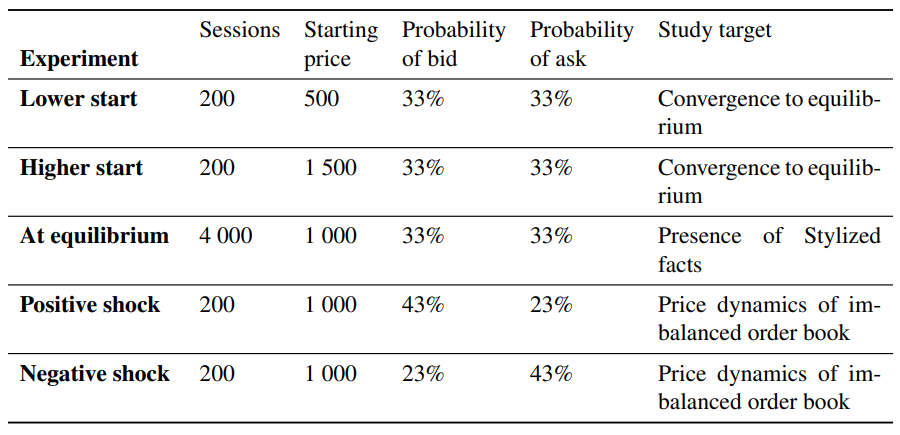

## Lower Start

In [ ]:
if ~isdir("results/basic_upd_lower")
    mkdir("results/basic_upd_lower")
end
#include("src/botmarket.jl")
#using .BotMarket

generic_stock = FixedAsset(0., name="stock")
generic_currency = FixedAsset(0., name="currency")

assets = [generic_stock, generic_currency]

# session
world = ExternalWorld()

investors = [
    ZeroIntelligentInvestor(
        Dict{AbstractAsset, Int64}(generic_currency=>100_000_00, generic_stock=>10_000);
        deviation=20
    )
    for i in 1:10000
]
markets = [
    DoubleAuctionMarket(generic_stock, generic_currency, name="Ccy --> Stock"),
]



markets[1].last_price = 500
#markets[2].last_price = 0
trading_days = 200

run_simulation(investors, markets, assets, trading_days, 1.0, "basic_upd_lower")

## Higher Start

In [ ]:
if ~isdir("results/basic_upd_higher")
    mkdir("results/basic_upd_higher")
end
#include("src/botmarket.jl")
#using .BotMarket

generic_stock = FixedAsset(0., name="stock")
generic_currency = FixedAsset(0., name="currency")

assets = [generic_stock, generic_currency]

# session
world = ExternalWorld()

investors = [
    ZeroIntelligentInvestor(
        Dict{AbstractAsset, Int64}(generic_currency=>100_000_00, generic_stock=>10_000);
        deviation=20
    )
    for i in 1:10000
]
markets = [
    DoubleAuctionMarket(generic_stock, generic_currency, name="Ccy --> Stock"),
]



markets[1].last_price = 1500
#markets[2].last_price = 0
trading_days = 200

run_simulation(investors, markets, assets, trading_days, 1.0, "basic_upd_higher")

## At equilibrium

In [ ]:
if ~isdir("results/basic_upd")
    mkdir("results/basic_upd")
end
#include("src/botmarket.jl")
#using .BotMarket

generic_stock = FixedAsset(0., name="stock")
generic_currency = FixedAsset(0., name="currency")

assets = [generic_stock, generic_currency]

# session
world = ExternalWorld()

investors = [
    ZeroIntelligentInvestor(
        Dict{AbstractAsset, Int64}(generic_currency=>100_000_00, generic_stock=>10_000);
        deviation=20
    )
    for i in 1:10000
]
markets = [
    DoubleAuctionMarket(generic_stock, generic_currency, name="Ccy --> Stock"),
]



markets[1].last_price = 1000
#markets[2].last_price = 0
trading_days = 4000

run_simulation(investors, markets, assets, trading_days, 1.0, "basic_upd")

## Shocks (Positive Shock & Negative Shock)
This simulation required pasting the run_simulation from main.jl here as both of the simulations are done on one go.

In [ ]:
# Disruption of market 

name = "shocks"
speak_ratio = 1.0

if ~isdir("results/$name")
    mkdir("results/$name")
end
#include("src/botmarket.jl")
#using .BotMarket

generic_stock = FixedAsset(0., name="stock")
generic_currency = FixedAsset(0., name="currency")

assets = [generic_stock, generic_currency]

# session
world = ExternalWorld()

investors = [
    ZeroIntelligentInvestor(
        Dict{AbstractAsset, Int64}(generic_currency=>100_000_00, generic_stock=>10_000);
        deviation=20
    )
    for i in 1:10000
]
markets = [
    DoubleAuctionMarket(generic_stock, generic_currency, name="Ccy --> Stock 1"),
]



markets[1].last_price = 900
trading_days = 1000



# Simulation

save_positions(investors, "results/$name/pos_start.csv")
trades = Dict{AbstractMarket, Array{Trade, 1}}(market => [] for market in markets)
df_books = DataFrame()

day_index = []
for day in 1:trading_days
    # Trading day
    #println("Trading day ", day)
    
    # Disruption
    if day == 200
        for inv in investors
            inv.side_weights[BidLimitOrder] = 2
            inv.side_weights[AskLimitOrder] = 4
            inv.side_weights[Nothing] = 3
        end
    elseif day == 400
        for inv in investors
            inv.side_weights[BidLimitOrder] = 3
            inv.side_weights[AskLimitOrder] = 3
            inv.side_weights[Nothing] = 3
        end
    elseif day == 600
        for inv in investors
            inv.side_weights[BidLimitOrder] = 4
            inv.side_weights[AskLimitOrder] = 2
            inv.side_weights[Nothing] = 3
        end
    elseif day == 800
        for inv in investors
            inv.side_weights[BidLimitOrder] = 3
            inv.side_weights[AskLimitOrder] = 3
            inv.side_weights[Nothing] = 3
        end
    elseif day == 2000
        for inv in investors
            inv.side_weights[BidLimitOrder] = 3
            inv.side_weights[AskLimitOrder] = 3
            inv.side_weights[Nothing] = 0
        end
    end

    session_trades = run_day(sample(investors, Int64(round(length(investors) * speak_ratio)), replace = false), markets)
    pay_cashflows!(investors, assets)
    update!(world)

    for market in keys(session_trades)
        trades[market] = vcat(trades[market], session_trades[market])
        end_price = length(session_trades[market]) > 0 ? session_trades[market][end].price : "<no trades>"
        println("Price of the day $day: $(end_price) ($(market.name))")
    end
    n_trades = sum([length(val) for val in values(session_trades)])
    day_index = vcat(day_index, repeat([day], n_trades))

    # Order book and its content
    df_book = get_market_books(markets)
    if ~isempty(df_book)
        df_book[!, :day] .= day
        df_books = vcat(df_books, df_book)
    end
end


save_positions(investors, "results/$name/pos_end.csv")

save_trades(trades, day_index, path="results/$name/trades.csv")
CSV.write("results/$name/books.csv", df_books)